In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path)

    # Downscale the image to 244x244, this is what ResNEt50 is trained on.
    img_rescaled = img.resize((244, 244), Image.Resampling.LANCZOS)
    img_array = img_to_array(img_rescaled)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

def preprocess_metadata(df):
    label_encoders = {}
    categorical_columns = ['sex', 'anatom_site_general', 'lesion_id']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    scaler = StandardScaler()
    df['age_approx'] = scaler.fit_transform(df[['age_approx']])

    return df


def load_data(df, image_folder):
    images = []
    metadata_features = []
    labels = []

    for _, row in df.iterrows():
        # Load and preprocess image
        img_path = f"{image_folder}/{row['image']}.jpg"  # Ensure the file extension is correct
        img = preprocess_image(img_path)
        images.append(img)

        # Extract metadata features
        metadata_features.append(row[['sex', 'anatom_site_general', 'lesion_id', 'age_approx']].values)

        # Extract the last 8 columns as labels
        labels.append(row.iloc[-8:].values)

    return np.array(images), np.array(metadata_features), np.array(labels)

In [5]:
image_folder = "archive/ISIC_2019_Training_Input"
metadata_csv = "archive/ISIC_2019_Training_Metadata.csv"
groundtruth_csv = "archive/ISIC_2019_Training_GroundTruth.csv"

metadata = pd.read_csv(metadata_csv)
groundtruth = pd.read_csv(groundtruth_csv)

# Drop the 'UNK' class column from groundtruth. 
# UNK stands for UNKNOWN, or "none of the above" and can
# be assigned last, if no other diagnosis was found.
groundtruth = groundtruth.drop(columns=["UNK"])

# Fill with "Unknown" if feature is empty
metadata["anatom_site_general"] = metadata["anatom_site_general"].fillna("unknown")
metadata["lesion_id"] = metadata["lesion_id"].fillna("unknown")
metadata["sex"] = metadata["sex"].fillna("unknown")

# Use the median age if no age is specified 
metadata["age_approx"] = metadata["age_approx"].fillna(metadata["age_approx"].median())

# Merge metadata with labels
data = metadata.merge(groundtruth, on="image")  # Assuming "image" is the common column

# Split into train and test
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42, stratify=data.iloc[:, -8:])  # Last 8 columns are labels


# Load train and test datasets
X_train_images, X_train_metadata, y_train = load_data(train_df, image_folder)
X_test_images, X_test_metadata, y_test = load_data(test_df, image_folder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..129.061].


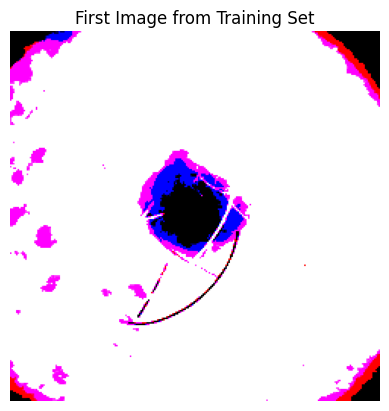

In [ ]:
plt.imshow(X_train_images[0])
plt.axis("off")
plt.title("First Image from Training Set")
plt.show()